In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### file hierarchy and database connection vars

In [2]:
# directory & file hierarchy
iterationName = 'Bingphotodraw_pilot'
exp_path = 'photodraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['Bing_photodraw_e1']


### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [4]:
# experiment_name = 'Bingphotodraw_pilot'
experiment_name = 'Bing_photodraw_e1'

all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find().distinct('sessionId')
print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), experiment_name)


ServerSelectionTimeoutError: 127.0.0.1:27017: [Errno 61] Connection refused

105

In [110]:
really_run_this = 1
if really_run_this:
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    kidName = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    draw_duration = []
    filename = []
    countErr = 0
    condition=[]
    subID=[]
    
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        for imrec in image_recs:   
            if imrec['subID']!="Sub01" and imrec['subID']!="Test01" and imrec['subID']!="Test02" and imrec['subID']!="Test04":
                stroke_recs = this_collection.find({'$and': [ 
                                                  {'sessionId':s}, 
                                                  {'dataType':'stroke'},
                                                  {'trialNum': imrec['trialNum']}]}).sort('time')   

                if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                    session_id.append(imrec['sessionId'])        
                    trial_num.append(imrec['trialNum']) 
                    category.append(imrec['category'])
 
                    try:    
                        png.append(imrec['imgData'])
                        submit_time.append(imrec['time'])
                        submit_date.append(imrec['date'])
                        condition.append(imrec['condition'])
                        subID.append(imrec['subID'])
                        filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}_{}.png'.format(imrec['category'], imrec['subID'],imrec['sessionId'], imrec['condition'])))
                        num_strokes.append(stroke_recs.count())
                        _svg = [] # this keeps track of the strokes from THIS final image
                        _svg_times = []
                        for strec in stroke_recs:
                            _svg.append(strec['svg'])
                            _svg_times.append(strec['time'])
                        draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                        svg.append(_svg)
                        svg_times.append(_svg_times)

                        ## and write out image data here too
                        imgData = imrec['imgData'];
                        filestr = base64.b64decode(imgData)
                        child_dir = os.path.join(sketch_dir,imrec['kidName'])
                        if not os.path.exists(child_dir):
                            os.makedirs(child_dir)
                        fname = os.path.join(child_dir,'{}_sketch_{}_{}_{}.png'.format(imrec['category'], imrec['subID'],imrec['sessionId'],imrec['condition']))
                        with open(fname, "wb") as fh:
                            fh.write(imgData.decode('base64'))  
                    except:
                        print('something went wrong with an image')
                        countErr = countErr + 1
                        print imrec['category']
                        child_dir = os.path.join(sketch_dir,'noname')
                        if not os.path.exists(child_dir):
                            os.makedirs(child_dir)
                        fname = os.path.join(child_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], 'noname',imrec['sessionId']))
                        with open(fname, "wb") as fh:
                            fh.write(imgData.decode('base64'))  
                        

In [11]:
imrec

{u'_id': ObjectId('5b44e45807aab50b0de228ce'),
 u'category': u'this shape',
 u'condition': u'S',
 u'counter_balancing': u'1',
 u'dataType': u'finalImage',
 u'date': u'2018-07-10T16:52:40.747Z',
 u'imgData': u'iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAAAAAXNSR0IArs4c6QAAAaFJREFUeAHt0DEBAAAAwqD1T20LL4hAYcCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQO/gQFgNQAB6po22QAAAABJRU5ErkJggg==',
 u'kidName': u'TEST TEST',
 u'location': u'Bing',
 u'sessionId': u'Bingphotodraw_pilot1531241475109',
 u'time': 1531241560747.0,
 u'tria

In [111]:
if really_run_this:
    X = pd.DataFrame([session_id,trial_num,condition,category,subID,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename])
    X = X.transpose()
    X.columns = ['session_id','trial_num','condition','category','subID','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration', 'filename']



In [112]:
X

,session_id,trial_num,condition,category,subID,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename
0,Bing_photodraw_e11531411158419,0,S,this square,Sub02,1.53141e+12,2018-07-12T16:56:35.788Z,7,"[M322.71875,304.51563, M372.71875,355.51563l-1...","[1.53141456708e+12, 1.53141457248e+12, 1.53141...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,21.803,/Users/langcogresearchassistants/Desktop/kiddr...
1,Bing_photodraw_e11531411158419,1,S,this shape,Sub02,1.53141e+12,2018-07-12T16:57:13.564Z,1,"[M361.71875,49.51563l2,2v1v1v2v2v1v1v1v1v1v1v1...",[1.53141461989e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/langcogresearchassistants/Desktop/kiddr...
2,Bing_photodraw_e11531411158419,2,S,this circle,Sub02,1.53141e+12,2018-07-12T16:57:50.871Z,13,"[M268.71875,339.51563l-8,-3h-1h-1l-1,-1h-1h-1h...","[1.53141464648e+12, 1.53141464648e+12, 1.53141...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,22.823,/Users/langcogresearchassistants/Desktop/kiddr...
3,Bing_photodraw_e11531411158419,3,W,cup,Sub02,1.53141e+12,2018-07-12T16:58:34.808Z,5,"[M376.71875,138.51563l2,-6l2,-4l4,-4l4,-3l4,-3...","[1.5314146903e+12, 1.53141469563e+12, 1.531414...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,22.873,/Users/langcogresearchassistants/Desktop/kiddr...
4,Bing_photodraw_e11531411158419,4,W,train,Sub02,1.53141e+12,2018-07-12T16:59:12.111Z,3,"[M131.71875,104.51563l10,-1h4h5h5h5h4h5h7h5h7l...","[1.53141472834e+12, 1.53141473733e+12, 1.53141...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,20.86,/Users/langcogresearchassistants/Desktop/kiddr...
5,Bing_photodraw_e11531411158419,5,W,cat,Sub02,1.53141e+12,2018-07-12T16:59:49.551Z,2,"[M26.71875,11.51563l7,-6h7h7l33,-1h11l11,1l28,...","[1.5314147626e+12, 1.5314147626e+12]",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0.001,/Users/langcogresearchassistants/Desktop/kiddr...
6,Bing_photodraw_e11531411158419,6,W,rabbit,Sub02,1.53141e+12,2018-07-12T17:00:27.096Z,4,"[M280.71875,241.51563l-6,6l-5,9l-5,11l-6,12l-5...","[1.53141480079e+12, 1.53141480079e+12, 1.53141...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,26.053,/Users/langcogresearchassistants/Desktop/kiddr...
7,Bing_photodraw_e11531411158419,7,W,shoe,Sub02,1.53141e+12,2018-07-12T17:01:03.986Z,15,"[M425.71875,387.51563l-5,9v5v4l-1,6v6v6l-1,7v8...","[1.53141483955e+12, 1.53141484255e+12, 1.53141...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,23.896,/Users/langcogresearchassistants/Desktop/kiddr...
8,Bing_photodraw_e11531411158419,8,S,cup,Sub02,1.53141e+12,2018-07-12T17:01:46.874Z,2,"[M25.71875,656.51563l5,-3l1,-1h1h2l2,-1h2h3h2h...","[1.5314148813e+12, 1.53141488294e+12]",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,1.65,/Users/langcogresearchassistants/Desktop/kiddr...
9,Bing_photodraw_e11531411158419,9,S,rabbit,Sub02,1.53141e+12,2018-07-12T17:02:23.999Z,3,"[M626.71875,650.51563l-9,-1h-3h-3h-3h-4h-4h-5h...","[1.53141491707e+12, 1.53141491707e+12, 1.53141...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,8.833,/Users/langcogresearchassistants/Desktop/kiddr...


In [114]:
categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
num_ims = 0
ims_per_cat = []
for c in categories:
    num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
    ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
print num_ims
print ims_per_cat

357
[12, 16, 18, 18, 18, 2, 18, 17, 4, 18, 16, 14, 99, 17, 18, 16, 6, 16, 14]


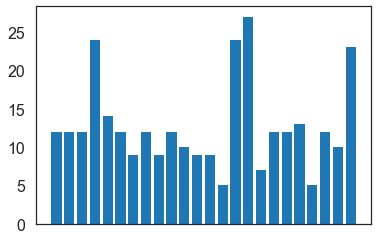

In [46]:
plt.bar(categories,ims_per_cat)
frame1=plt.gca()
frame1.axes.get_xaxis().set_visible(False)


In [63]:
X_out.draw_duration

0       1.892
1       0.951
2        1.03
3       0.791
4       1.002
5      12.327
6           0
7           0
8           0
9      24.511
10       6.05
11      5.641
12     12.046
13      6.698
14     10.237
15     11.801
16     18.474
17     19.045
18          0
19          0
20      0.782
21      1.268
22          0
23      0.788
24          0
25          0
26      7.088
27          0
28          0
29          0
        ...  
418      None
419      None
420      None
421      None
422      None
423      None
424      None
425      None
426      None
427      None
428      None
429      None
430      None
431      None
432      None
433      None
434      None
435      None
436      None
437      None
438      None
439      None
440      None
441      None
442      None
443      None
444      None
445      None
446      None
447      None
Name: draw_duration, Length: 448, dtype: object

### load drawing metadata csv back in

### Basic visualizations

Text(0.5,0,u'number of strokes')

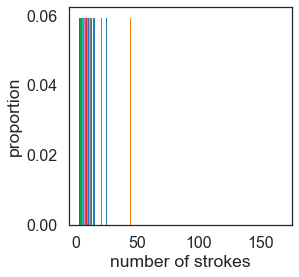

In [7]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

Text(0.5,0,u'draw duration')

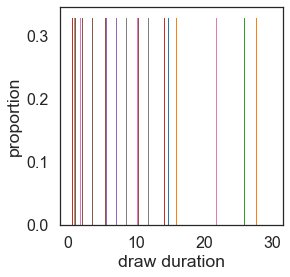

In [11]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

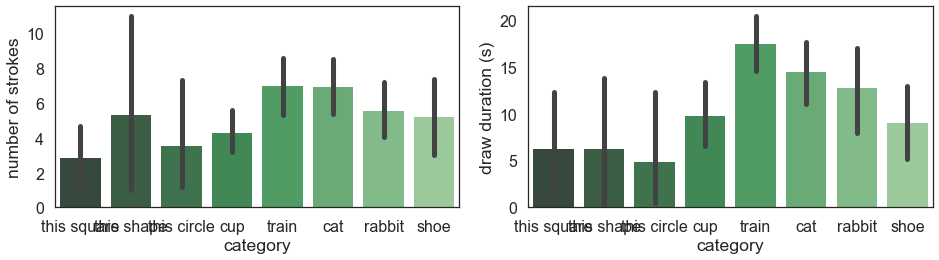

In [115]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='category',y='num_strokes',palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='category',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

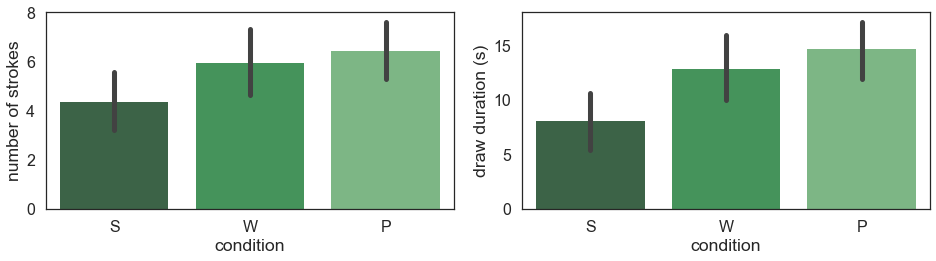

In [116]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='condition',y='num_strokes',palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='condition',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

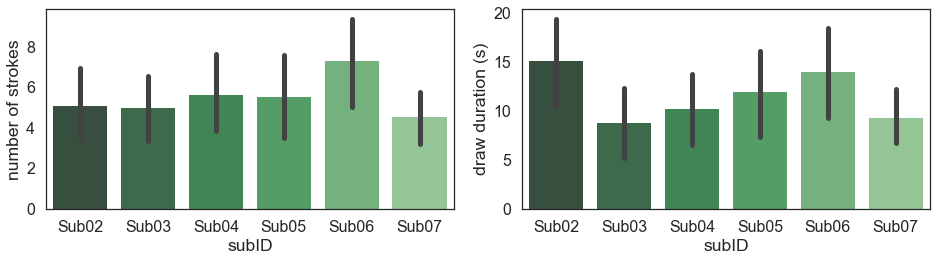

In [117]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='subID',y='num_strokes',palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='subID',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

In [14]:
unique = X.drop_duplicates(["session_id"])
unique.count()
# sum(unique.age != 'adult')
sum(unique.age != 'adult')

140

In [ ]:
X.

In [13]:
unique

,session_id,trial_num,category,age,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename
0,cdm_run_test1524766380234,0,square,adult,1.52477e+12,2018-04-26T18:13:19.827Z,2,"[M263,162.96875l-1,10l-1,5l-1,5l-2,7l-1,10l-2,...","[1.52476639554e+12, 1.52476639588e+12]",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0.337,/Users/brialong/Documents/GitHub/kiddraw/analy...
1,cdm_run_test1524766518460,0,square,age5,1.52477e+12,2018-04-26T18:17:34.102Z,1,"[M242,242.96875v1v1v2v2v3v2v3l-1,3v3l-1,5l-1,5...",[1.52476665118e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
3,stationPilot1_1524766676245,0,square,age5,1.52477e+12,2018-04-26T18:19:12.145Z,1,"[M232,212.96875v2v4l-1,3l-1,4l-2,3l-1,4l-1,3l-...",[1.52476674489e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
14,cdm_run_test1524767095441,0,square,age8,1.52477e+12,2018-04-26T18:30:05.270Z,135,"[M242,216.96875v3l-1,4l-1,4l-2,6l-1,5l-1,7l-1,...","[1.5247673804e+12, 1.52476738661e+12, 1.524767...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,22.229,/Users/brialong/Documents/GitHub/kiddraw/analy...
15,stationPilot1_1524767406267,0,square,age8,1.52477e+12,2018-04-26T18:30:30.271Z,2,"[M234,225.96875v1v1v1v1v1v1v1v1v2v2v2v3v2v4v3v...","[1.52476741993e+12, 1.52476742888e+12]",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,8.952,/Users/brialong/Documents/GitHub/kiddraw/analy...
18,stationPilot1_1524767460609,0,square,age9,1.52477e+12,2018-04-26T18:31:43.009Z,1,"[M265,248.96875v2v1v1h-1l-1,1h-1l-1,1h-1l-1,1l...",[1.52476750028e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
30,stationPilot1_1524767677268,0,square,age9,1.52477e+12,2018-04-26T18:35:11.560Z,1,"[M221,230.96875v1v2v2l1,1v2l1,1v1v2v1l1,1v2v2v...",[1.52476771043e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
32,cdm_run_test1524767999442,0,square,age8,1.52477e+12,2018-04-26T18:40:30.873Z,1,"[M189,222.96875v2v1v1v2v1v1v2l1,1v2l1,3l1,4l1,...",[1.52476802937e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
33,stationPilot1_1524768031714,0,square,age10,1.52477e+12,2018-04-26T18:41:05.915Z,1,"[M231,233.96875v1v1v1v1v2v2v1v2v2v2v1v1v1v2v1v...",[1.52476806297e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
40,stationPilot1_1524768165944,0,square,age9,1.52477e+12,2018-04-26T18:43:18.263Z,9,"[M228,543.96875l-5,-9l-4,-9l-2,-5l-3,-5l9,-34l...","[1.52476818331e+12, 1.52476818799e+12, 1.52476...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,11.481,/Users/brialong/Documents/GitHub/kiddraw/analy...


In [17]:
categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
num_ims = 0
ims_per_cat = []
for c in categories:
    num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
    ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
print num_ims
print ims_per_cat

1106
[78, 78, 82, 78, 82, 79, 80, 76, 135, 48, 172, 118]
